# データ取得

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/株価予測/all_stocks_5yr.csv", index_col=0)

In [ ]:
df

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...
2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS


# 期間指定

In [ ]:
import datetime as dt

In [ ]:
df[(df['date'] >= dt.datetime(2017,12,31)) & (df['date'] < dt.datetime(2018,12,31))]

In [ ]:
df[100 : 200]

,open,high,low,close,volume,Name
date,,,,,,
2013-07-03,16.06,16.80,16.04,16.75,2625800,AAL
2013-07-05,16.93,17.00,16.68,16.84,2397200,AAL
2013-07-08,16.94,17.09,16.85,16.94,2671200,AAL
2013-07-09,17.01,17.38,16.97,17.36,4076600,AAL
2013-07-10,17.32,17.48,17.01,17.17,4289700,AAL
...,...,...,...,...,...,...
2013-11-15,23.73,24.05,23.32,23.89,13660700,AAL
2013-11-18,24.22,24.81,24.04,24.40,10080800,AAL
2013-11-19,24.55,24.80,24.08,24.23,14087400,AAL


In [ ]:
df.loc['2018' : '2018']

KeyError: ignored

In [ ]:
df.drop(['volume', 'high', 'low', 'close', 'Name'], axis="columns", inplace=True)

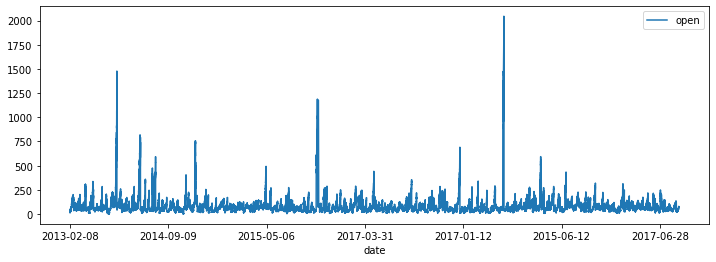

In [ ]:
df.plot(figsize=(12, 4))

# 正規化

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
y = df["open"].values
y

array([15.07, 14.89, 14.45, ..., 76.64, 72.74, 72.7 ])

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(y.reshape(-1, 1))
y = scaler.transform(y.reshape(-1, 1))

In [ ]:
y = torch.FloatTensor(y).view(-1)
y

tensor([-0.9868, -0.9870, -0.9874,  ..., -0.9265, -0.9304, -0.9304])

In [ ]:
test_size = 200

train_seq = y[:-test_size]
test_seq = y[-test_size:]

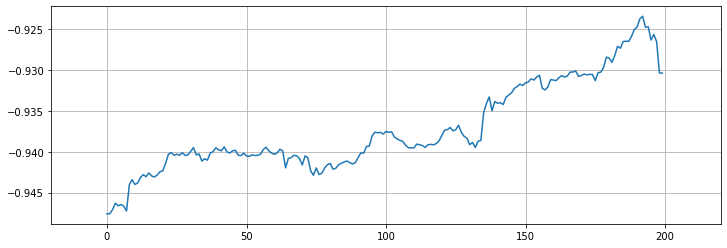

In [ ]:
plt.figure(figsize=(12, 4))
plt.xlim(-20, len(test_seq)+20)
plt.grid(True)
plt.plot(test_seq)

# テストデータ作成

In [ ]:
def input_data(data, size):
  out=[]
  L=len(data)

  for i in range(L-size):
    window = data[i:i+size]
    label = data[i+size:i+size+1]
    out.append((window, label))

  return out 

In [ ]:
train_window_size = 12

In [ ]:
train_data = input_data(train_seq, train_window_size)

In [ ]:
print("Training Dataの個数: ", len(train_data))

Training Dataの個数:  618828


In [ ]:
class Model(nn.Module):


    def __init__(self, input=1, h=50, output=1):
        super().__init__()
        self.hidden_size = h

        self.lstm = nn.LSTM(input, h)
        self.fc = nn.Linear(h, output)

        self.hidden = (
            torch.zeros(1, 1, h),
            torch.zeros(1, 1, h)
        )
    

    def forward(self, seq):

        out, _ = self.lstm(
            seq.view(len(seq), 1, -1),
            self.hidden
        )

        out = self.fc(
            out.view(len(seq), -1)
        )

        return out[-1]

In [ ]:
torch.manual_seed(123)
model = Model()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
epochs = 3
train_losses = []
test_losses = []

In [ ]:
def run_train():
    model.train()

    for train_window, correct_label in train_data:

        optimizer.zero_grad()

        model.hidden = (
            torch.zeros(1, 1, model.hidden_size),
            torch.zeros(1, 1, model.hidden_size)
        )

        train_predicted_label = model.forward(train_window)
        train_loss = criterion(train_predicted_label, correct_label)

        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss)

- a = torch.tensor([10])
- a.item()
10

In [ ]:
def run_test():
    model.eval()

    for i in range(test_size):

        test_window = torch.FloatTensor(extending_seq[-test_size:])

        with torch.no_grad():

            model.hidden = (
                torch.zeros(1, 1, model.hidden_size),
                torch.zeros(1, 1, model.hidden_size)
            )  
        
            test_predicted_label = model.forward(test_window)
            extending_seq.append(test_predicted_label.item())
    
    test_loss = criterion(
        torch.FloatTensor(extending_seq[-test_size:]),
        y[len(y)-test_size:]
    )

    test_losses.append(test_loss)

In [ ]:
for epoch in range(epochs):

    print()
    print(f'Epoch: {epoch+1}')

    run_train()

    extending_seq = train_seq[-test_size:].tolist()

    run_test()

    plt.figure(figsize=(12, 4))
    plt.xlim(-20, len(y)+20)
    plt.grid(True)

    plt.plot(y.numpy())

    plt.plot(
        range(len(y)-test_size, len(y)),
        extending_seq[-test_size:]
    )

    plt.show()


Epoch: 1


In [ ]:
# 誤差がどのように収束しいったか
plt.plot(train_losses)

In [ ]:
plt.plot(test_losses)

In [ ]:
predicted_normalized_labels_list = extending_seq[-test_size:]

In [ ]:
predicted_normalized_labels_array_1d = np.array(predicted_normalized_labels_list)
predicted_normalized_labels_array_1d

In [ ]:
predicted_normalized_labels_array_2d = predicted_normalized_labels_array_1d.reshape(-1, 1)
predicted_normalized_labels_array_2d

In [ ]:
predicted_labels_array_2d = scaler.inverse_transform(predicted_normalized_labels_array_2d)
predicted_labels_array_2d

In [ ]:
len(predicted_labels_array_2d)

In [ ]:
ｄｆ["open"][-test_size:]

In [ ]:
len(df["open"][-test_size:])

In [ ]:
ｄｆ.index

In [ ]:
x_2018_10_to_2020_09 = np.arange('2018-10', '2020-10', dtype='datetime64[M]')
x_2018_10_to_2020_09

In [ ]:
fig = plt.figure(figsize=(12, 4))
plt.title('Stock Price Prediction')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

plt.plot(stock_data["Adj Close"]['2016-01':])
plt.plot(x_2018_10_to_2020_09, predicted_labels_array_2d)
plt.show()

In [ ]:
stock_data["Adj Close"]['2018-10':]